In [84]:
from ultralytics import YOLO

from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image

import cv2

from shapely.geometry import Polygon

import re
import cbvision
import chess


In [85]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [86]:
# calculates iou between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [87]:
def detect_corners(image):
    
    # YOLO model trained to detect corners on a chessboard
    model_trained = YOLO("best_corners.pt")
    results = model_trained.predict(source=image, line_width=1, conf=0.25, save_txt=True, save=True)

    # get the corners coordinates from the model
    boxes = results[0].boxes
    arr = boxes.xywh.numpy()
    points = arr[:,0:2]
    
    corners = order_points(points)
    
    return corners  

In [88]:
# perspective transforms an image with four given corners

def four_point_transform(image, pts):
      
    img = Image.open(image)
    image = asarray(img)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
   

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    # img.show()    
    # return the warped image
    return img

In [89]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [90]:
# detects chess pieces

def chess_pieces_detector(image):
    
    model_trained = YOLO("best_transformed_detection.pt")
    results = model_trained.predict(source=image, line_width=1, conf=0.5, augment=False, save_txt=True, save=True)
    
    boxes = results[0].boxes
    detections = boxes.xyxy.numpy()
    
    return detections, boxes

In [91]:
# connects detected piece to the right square

def connect_square_to_detection(detections, square):
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q', 5: 'r', 
      6: 'B', 7: 'K', 8: 'N',
      9: 'P', 10: 'Q', 11: 'R'}

    list_of_iou=[]
    
    for i in detections:

        box_x1 = i[0]
        box_y1 = i[1]

        box_x2 = i[2]
        box_y2 = i[1]

        box_x3 = i[2]
        box_y3 = i[3]

        box_x4 = i[0]
        box_y4 = i[3]
        
        #cut high pieces        
        if box_y4 - box_y1 > 60:
            box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
        else:
            box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
            
        #until here

        list_of_iou.append(calculate_iou(box_complete, square))

    num = list_of_iou.index(max(list_of_iou))

    piece = boxes.cls[num].tolist()
    
    if max(list_of_iou) > 0.15:
        piece = boxes.cls[num].tolist()
        return di[piece]
    
    else:
        piece = "empty"
        return piece

In [92]:
def fix_fen(fen):
    rows = fen.split("/")
    fixed_rows = []
    for row in rows:
        # Replace consecutive 1s with their count
        fixed_row = re.sub(r"1+", lambda m: str(len(m.group())), row)
        fixed_rows.append(fixed_row)
    return "/".join(fixed_rows)

In [93]:
def transform_image(image, corners):
    image = asarray(image)
    rect = order_points(corners)

    maxWidth = 1500; maxHeight = 1500

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    transformed_image = Image.fromarray(warped, "RGB")
    transformed_image.save("transform_for_model.jpg", "JPEG")
    return transformed_image

## Complete


0: 640x480 4 corners, 90.5ms
Speed: 8.0ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict241
1 label saved to runs\detect\predict241\labels

0: 1280x1280 3 Black Bishops, 1 Black King, 2 Black Knights, 8 Black Pawns, 1 Black Rook, 2 White Bishops, 1 White King, 2 White Knights, 9 White Pawns, 2 White Queens, 2 White Rooks, 4065.9ms
Speed: 40.2ms preprocess, 4065.9ms inference, 9.1ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\predict242
1 label saved to runs\detect\predict242\labels
['R', 'N', 'P', 'Q', 'K', 'Q', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'b', 'k', 'b', 'n', '1']
https://lichess.org/analysis/RNPQKQNR/PPPPPPPP/11111111/11111111/11111111/1

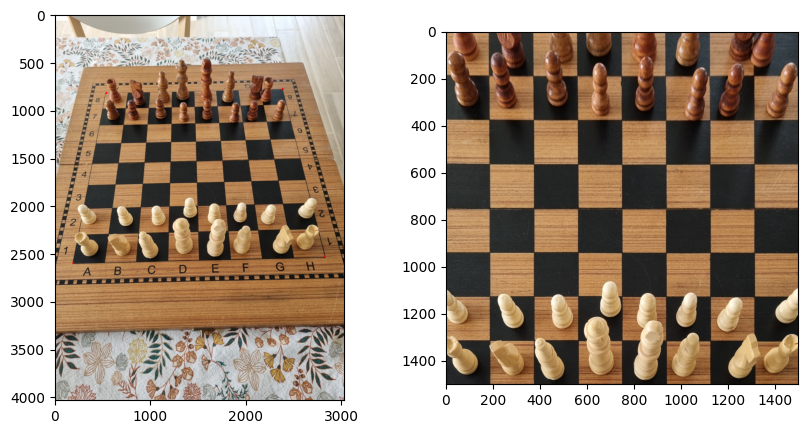

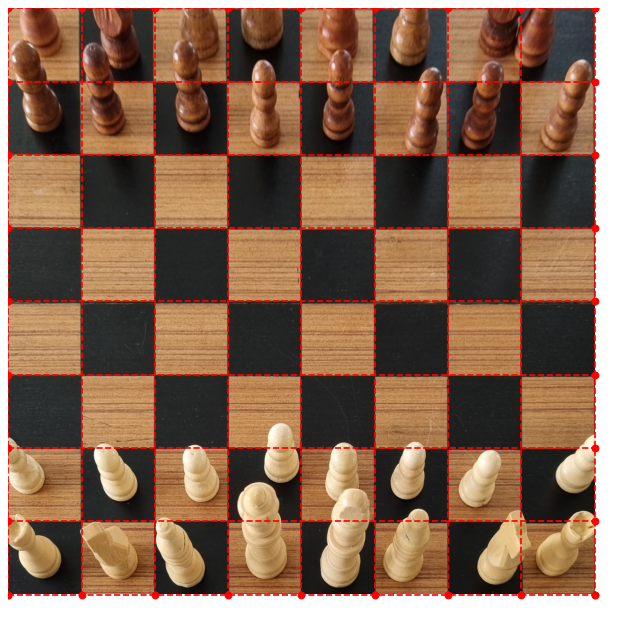

In [94]:
image = "image_data/1.jpg"

image = cv2.imread(image)

corners = detect_corners(image)

# Draw the points on the image
for point in corners:
    cv2.circle(image, tuple(point.astype(int)), 5, (0, 0, 255), 10)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transformed_image = transform_image(image, corners)

plt.figure(figsize =(10, 5))
plt.subplot(121);plt.imshow(image)
plt.subplot(122);plt.imshow(transformed_image)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)

detections, boxes = chess_pieces_detector(transformed_image)

# Extract x and y coordinates
x_coords = [ptsT[i][0] for i in range(9)]
y_coords = [ptsL[i][1] for i in range(9)]

# Generate all squares using loops
FEN_annotation = []
for row in range(8, 0, -1):  # Rows 8 to 1
    row_squares = []
    for col in range(8):  # Columns A to H (0 to 7 index)
        square = np.array([
            [x_coords[col], y_coords[row]],
            [x_coords[col + 1], y_coords[row]],
            [x_coords[col + 1], y_coords[row - 1]],
            [x_coords[col], y_coords[row - 1]]
        ])
        row_squares.append(square)
    FEN_annotation.append(row_squares)

board_FEN = []
corrected_FEN = []
complete_board_FEN = []

for line in FEN_annotation:
    line_to_FEN = []
    for square in line:
        piece_on_square = connect_square_to_detection(detections, square)    
        line_to_FEN.append(piece_on_square)
    corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
    print(corrected_FEN)
    board_FEN.append(corrected_FEN)

complete_board_FEN = [''.join(line) for line in board_FEN] 

to_FEN = '/'.join(complete_board_FEN)

print("https://lichess.org/analysis/"+to_FEN)



0: 640x480 4 corners, 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict243
1 label saved to runs\detect\predict243\labels

0: 1280x1280 3 Black Bishops, 1 Black King, 2 Black Knights, 8 Black Pawns, 1 Black Rook, 2 White Bishops, 1 White King, 2 White Knights, 9 White Pawns, 2 White Queens, 2 White Rooks, 3687.2ms
Speed: 25.1ms preprocess, 3687.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\predict244
1 label saved to runs\detect\predict244\labels
['R', 'N', 'P', 'Q', 'K', 'Q', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'b', 'k', 'b', 'n', '1']
RNPQKQNR/PPPPPPPP/8/8/8/8/pppppppp/rnbbkbn1


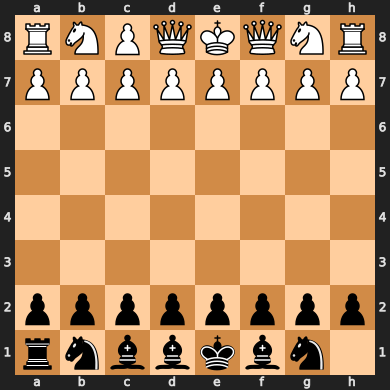

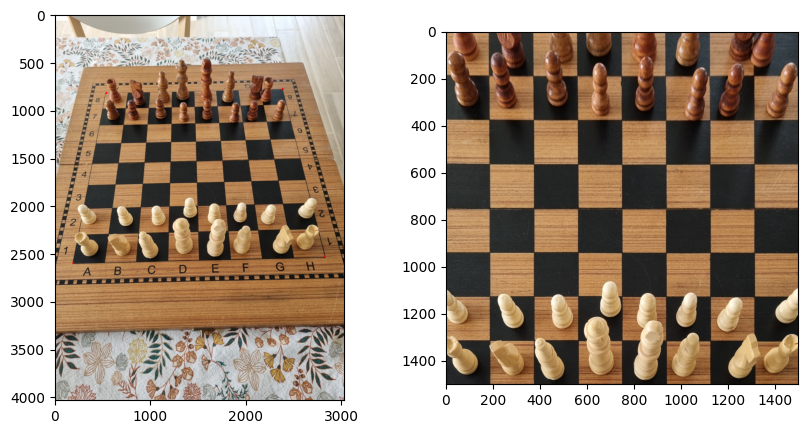

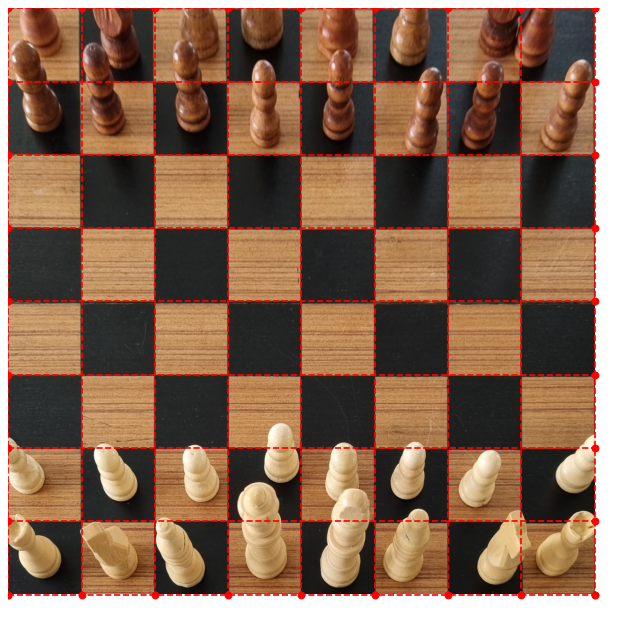

In [95]:
calculated_FEN = cbvision.get_fen("image_data/1.jpg")
print(calculated_FEN)

board = chess.Board(calculated_FEN)

display(board)



0: 1280x1280 3 Black Bishops, 1 Black King, 2 Black Knights, 8 Black Pawns, 1 Black Rook, 2 White Bishops, 1 White King, 2 White Knights, 9 White Pawns, 2 White Queens, 2 White Rooks, 5358.7ms
Speed: 25.5ms preprocess, 5358.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\predict269
1 label saved to runs\detect\predict269\labels

0: 1280x1280 1 Black Bishop, 1 Black Knight, 9 Black Pawns, 2 Black Queens, 1 Black Rook, 2 White Bishops, 1 White King, 2 White Knights, 9 White Pawns, 2 White Queens, 3 White Rooks, 5158.4ms
Speed: 26.9ms preprocess, 5158.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\detect\predict270
1 label saved to runs\detect\predict270\labels

0: 1280x1280 1 Black Bishop, 1 Black Knight, 11 Black Pawns, 3 Black Queens, 1 Black Rook, 1 White Bishop, 1 White King, 2 White Knights, 8 White Pawns, 2 White Queens, 1 White Rook, 5170.3ms
Speed: 33.1ms preprocess, 5170.3ms infere

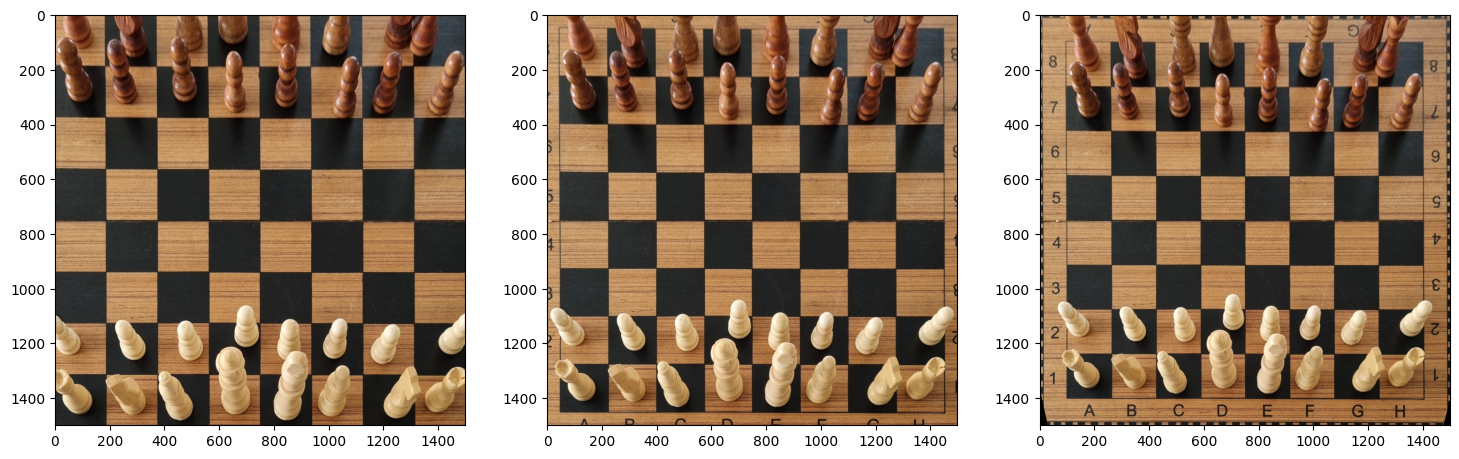

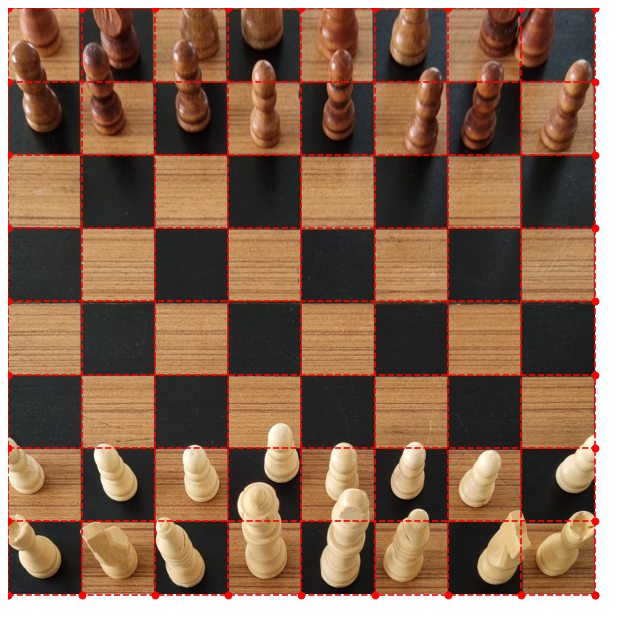

In [117]:
def tImgwithExtraBoard(image, corners, borderA):
    image = asarray(image)
    rect = order_points(corners)

    maxWidth = 1500; maxHeight = 1500

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [borderA, borderA],
        [maxWidth - borderA, borderA],
        [maxWidth - borderA, maxHeight - borderA],
        [borderA, maxHeight - borderA]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    transformed_image = Image.fromarray(warped, "RGB")
    return transformed_image

image = cv2.imread("image_data/1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tImg1 = tImgwithExtraBoard(image, corners, 0)
tImg2 = tImgwithExtraBoard(image, corners, 50)
tImg3 = tImgwithExtraBoard(image, corners, 100)

trans_im = transform_image(image, corners)

plt.figure(figsize =(18, 10))
plt.subplot(131);plt.imshow(tImg1)
plt.subplot(132);plt.imshow(tImg2)
plt.subplot(133);plt.imshow(tImg3)

detections1, boxes1 = chess_pieces_detector(tImg1)
detections2, boxes2 = chess_pieces_detector(tImg2)
detections3, boxes3 = chess_pieces_detector(tImg3)

ptsT, ptsL = plot_grid_on_transformed_image(trans_im)

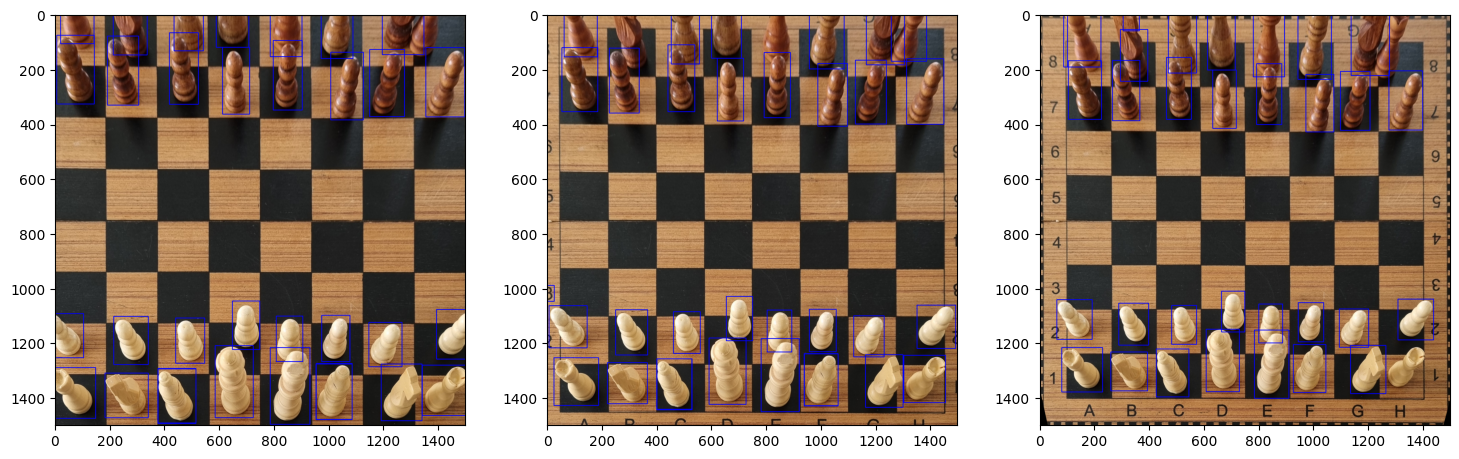

In [118]:
def drawBoundingBoxes(detections, image):
    for i in detections:

        box_x1 = i[0]
        box_y1 = i[1]

        box_x2 = i[2]
        box_y2 = i[1]

        box_x3 = i[2]
        box_y3 = i[3]
        box_x4 = i[0]
        box_y4 = i[3]
        
        box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])

        start_point = tuple(map(int, box_complete[0]))  # Convert [584.96, 1250.8] to (584, 1250)
        end_point = tuple(map(int, box_complete[2]))    # Convert the bottom-right corner similarly

        # Draw the rectangle on the image
        cv2.rectangle(image, start_point, end_point, (0, 0, 255), 2)

    return image

t1copy = tImg1.copy()
t1copy = np.array(t1copy)
t1copy = drawBoundingBoxes(detections1, t1copy)

t2copy = tImg2.copy()
t2copy = np.array(t2copy)
t2copy = drawBoundingBoxes(detections2, t2copy)

t3copy = tImg3.copy()
t3copy = np.array(t3copy)
t3copy = drawBoundingBoxes(detections3, t3copy)

plt.figure(figsize =(18, 10))
plt.subplot(131);plt.imshow(t1copy)
plt.subplot(132);plt.imshow(t2copy)
plt.subplot(133);plt.imshow(t3copy)
            

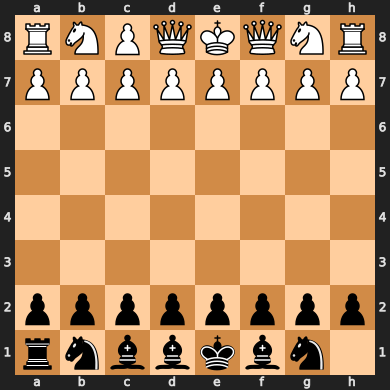

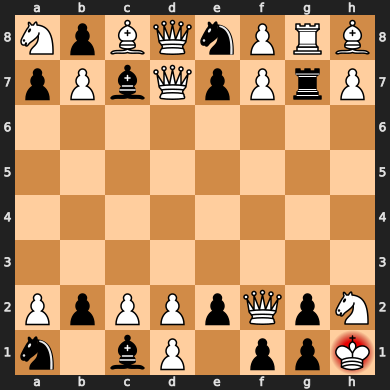

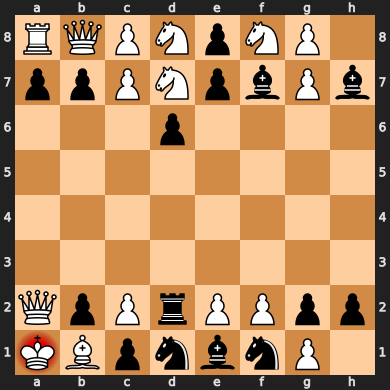

In [119]:
def to_FEN(ptsT, ptsL, detections):
    # Extract x and y coordinates
    x_coords = [ptsT[i][0] for i in range(9)]
    y_coords = [ptsL[i][1] for i in range(9)]

    # Generate all squares using loops
    FEN_annotation = []
    for row in range(8, 0, -1):  # Rows 8 to 1
        row_squares = []
        for col in range(8):  # Columns A to H (0 to 7 index)
            square = np.array([
                [x_coords[col], y_coords[row]],
                [x_coords[col + 1], y_coords[row]],
                [x_coords[col + 1], y_coords[row - 1]],
                [x_coords[col], y_coords[row - 1]]
            ])
            row_squares.append(square)
        FEN_annotation.append(row_squares)

    board_FEN = []
    corrected_FEN = []
    complete_board_FEN = []

    for line in FEN_annotation:
        line_to_FEN = []
        for square in line:
            piece_on_square = connect_square_to_detection(detections, square)    
            line_to_FEN.append(piece_on_square)
        corrected_FEN = [i.replace('empty', '1') for i in line_to_FEN]
        #print(corrected_FEN)
        board_FEN.append(corrected_FEN)

    complete_board_FEN = [''.join(line) for line in board_FEN] 
    to_FEN = '/'.join(complete_board_FEN)
    correct_FEN = fix_fen(to_FEN)

    return correct_FEN

fen1 = to_FEN(ptsT, ptsL, detections1)
fen2 = to_FEN(ptsT, ptsL, detections2)
fen3 = to_FEN(ptsT, ptsL, detections3)

cb1 = chess.Board(fen1)
cb2 = chess.Board(fen2)
cb3 = chess.Board(fen3)

display(cb1)
display(cb2)
display(cb3)

loading Roboflow workspace...
loading Roboflow project...


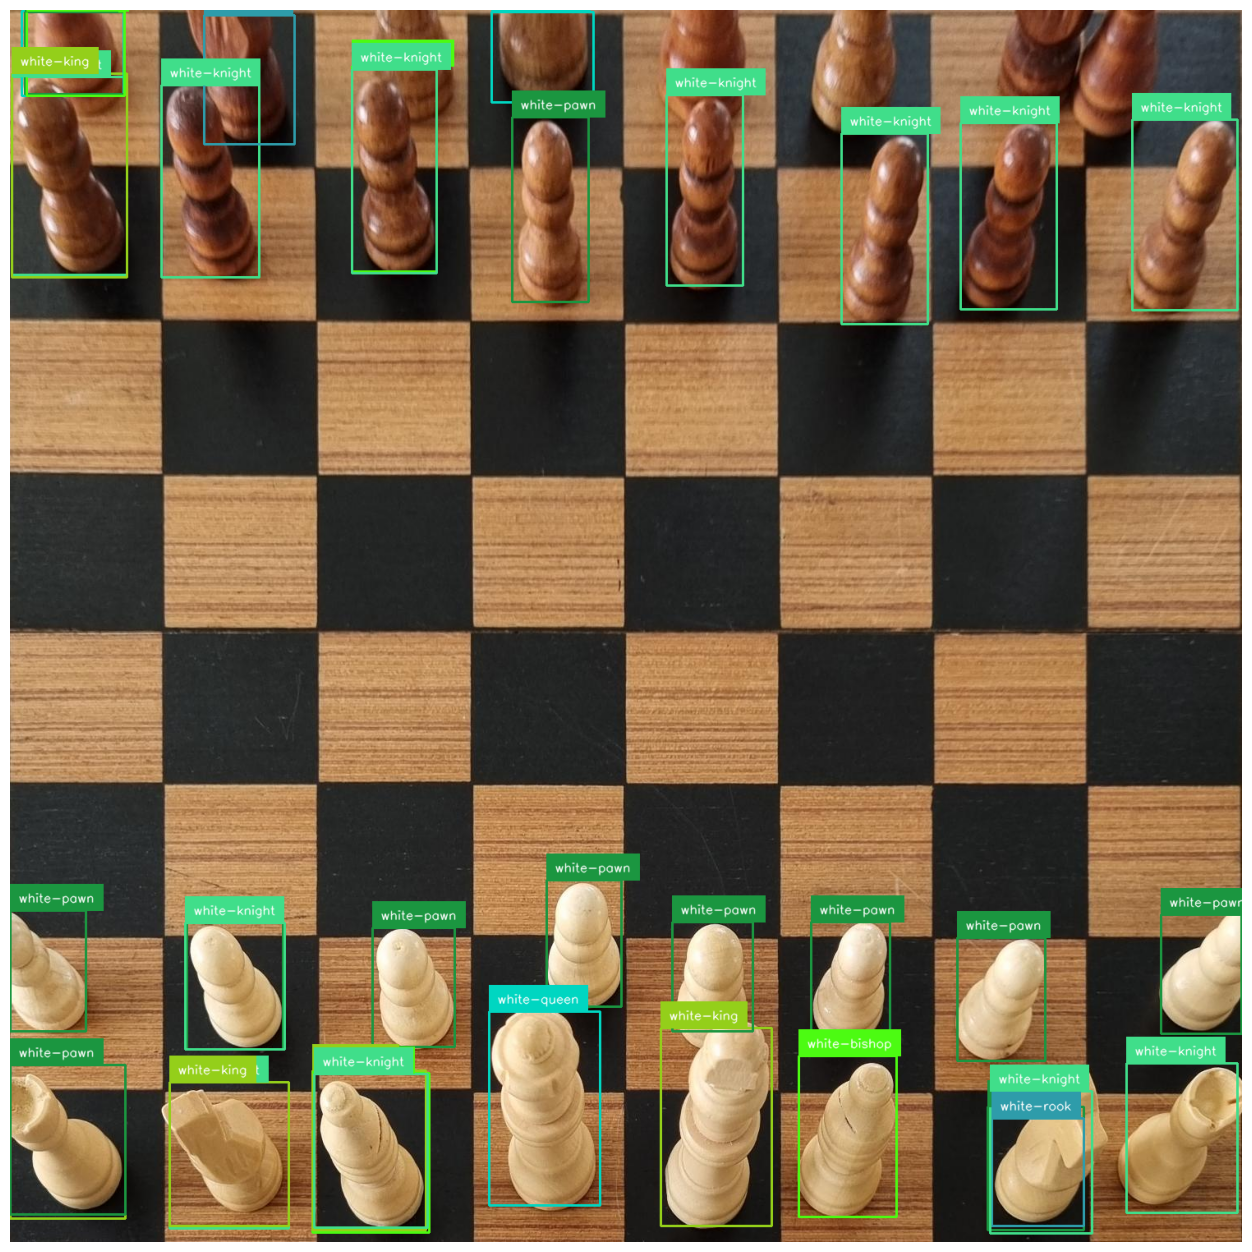

In [ ]:
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np

filename = "transform_for_model.jpg"

rf = Roboflow(api_key="SLOveDUxEQVdVuiM9IfM")
project = rf.workspace().project("chess-bprbi")
model = project.version(4).model

result = model.predict(filename, confidence=40, overlap=30).json()

labels = [item["class"] for item in result["predictions"]]

# Extract necessary values using list comprehensions
xyxy = np.array([[item["x"] - (item["width"] / 2), item["y"] - (item["height"] / 2), item["x"] + (item["width"] / 2), item["y"] + item["height"] / 2] for item in result["predictions"]])

confidences = np.array([item["confidence"] for item in result["predictions"]])
class_ids = np.array([item["class_id"] for item in result["predictions"]])

# Create a Detections object
detections = sv.Detections(xyxy=xyxy, confidence=confidences, class_id=class_ids)

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

image = cv2.imread(filename)

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))

In [100]:
print(result)

{'predictions': [{'x': 2331, 'y': 378, 'width': 277, 'height': 245, 'confidence': 0.8491044044494629, 'class': 'white-queen', 'class_id': 10, 'detection_id': '001a8855-1260-40b6-87ae-ee7d4d612b56', 'image_path': 'image_data/1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 2331, 'y': 375, 'width': 252, 'height': 231, 'confidence': 0.8474764823913574, 'class': 'white-bishop', 'class_id': 6, 'detection_id': '3a635e2b-1adb-4daf-8bd0-d9d08f0d64ef', 'image_path': 'image_data/1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 2019, 'y': 387, 'width': 233, 'height': 207, 'confidence': 0.8415712714195251, 'class': 'white-knight', 'class_id': 8, 'detection_id': 'a9b5f284-4503-43a7-9555-fef7b1e4e444', 'image_path': 'image_data/1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 2359, 'y': 1070, 'width': 308, 'height': 222, 'confidence': 0.8334423899650574, 'class': 'white-queen', 'class_id': 10, 'detection_id': 'e15a6f14-2510-4c6d-a535-25b68cc0eaa8', 'image_path': 'image_dat